In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import ESC

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2669161006692345725
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 492433738376269704
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6430611133556925721
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16504077256252367727
physical_device_desc: "device: XLA_GPU device"
]


## Define the Network

In [2]:
PiczakNet = ESC.PiczakNet([60, 41, 2])

print(PiczakNet.summary())

plot_model(PiczakNet, show_shapes=True, show_layer_names=True)

opt = tf.keras.optimizers.Adam(lr=0.0002)
PiczakNet.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "PiczakNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 2)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 41, 80)        54800     
_________________________________________________________________
activation (Activation)      (None, 60, 41, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 14, 80)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 14, 80)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 14, 80)        19280     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 14, 80)        0 

## Load Data

In [3]:
# Load raw data
PATH = 'audio'
raw_files, cvs, labels = ESC.Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = ESC.Split_Folds(raw_files, cvs, labels, verbose=True)

# Load
af1, alf1 = ESC.Split_Data_Label(f1)
af2, alf2 = ESC.Split_Data_Label(f2)
af3, alf3 = ESC.Split_Data_Label(f3)
af4, alf4 = ESC.Split_Data_Label(f4)
af5, alf5 = ESC.Split_Data_Label(f5)

'''
af1, alf1 = ESC.Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = ESC.Load_Augmented(name='af2', path='Augmented_2/')
af3, alf3 = ESC.Load_Augmented(name='af3', path='Augmented_2/')
af4, alf4 = ESC.Load_Augmented(name='af4', path='Augmented_2/')
af5, alf5 = ESC.Load_Augmented(name='af5', path='Augmented_2/')
'''

100%|██████████| 2000/2000 [00:00<00:00, 661092.92it/s]

Folds size: 400 - 400 - 400 - 400 - 400
Folds sample shape:  2
Folds sample data shape:  (110250,)
Folds sample label type:  (50,)


"\naf1, alf1 = ESC.Load_Augmented(name='af1', path='Augmented_2/')\naf2, alf2 = ESC.Load_Augmented(name='af2', path='Augmented_2/')\naf3, alf3 = ESC.Load_Augmented(name='af3', path='Augmented_2/')\naf4, alf4 = ESC.Load_Augmented(name='af4', path='Augmented_2/')\naf5, alf5 = ESC.Load_Augmented(name='af5', path='Augmented_2/')\n"

In [4]:
def Filtered_Preprocessing(raw_audio, labels, threshold=0.0001, bands=60, frames=41):
    '''
        Input:
            raw_audio:     list that contains the raw/augmented data
            labels:        list that contains the category information
            bands:         number of mel band to use
            frames:        number of frames to use
        
        Output:
            features:      numpy array that contains processed audio data with log-melspec and delta
            new_labels:    new labels for each augmented segment
    '''    

    
    segments = []
    segment_labels = []
    
    augmented_spec = []
    new_labels = []
    log_specgrams = []
    
    # Normalize the raw data
    #norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    #raw_audio = raw_audio / norm_factor
    
    # Loop over each file audio and divide into segments
    for num, audio in enumerate(tqdm(raw_audio)):
    
        # Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
        for idx in range(0, len(raw_audio[0]), int(20480/2)):
            
            tmp_audio = audio[idx:idx+20480]
            
            if len(tmp_audio) == 20480: 
                melspec = librosa.feature.melspectrogram(audio[idx:idx+20480], n_mels=bands)
                logspec = librosa.core.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                segment_labels.append(labels[num])
    

    # Reshape the outputs
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams), bands, frames, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    new_labels = np.asarray(segment_labels, dtype=np.float32)
    
    # Fill the delta features
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    features = features.astype(np.float32)
    labels = labels.astype(np.int)
    
    return features, new_labels

In [5]:
# Compute the features
f1_processed, lf1_processed = Filtered_Preprocessing(af1, alf1)
f2_processed, lf2_processed = Filtered_Preprocessing(af2, alf2)
f3_processed, lf3_processed = Filtered_Preprocessing(af3, alf3)
f4_processed, lf4_processed = Filtered_Preprocessing(af4, alf4)
f5_processed, lf5_processed = Filtered_Preprocessing(af5, alf5)

100%|██████████| 400/400 [00:08<00:00, 47.04it/s]


In [6]:
print('Shape f1: ', f1_processed.shape)
print('Shape f2: ', f2_processed.shape)
print('Shape f2: ', f3_processed.shape)
print('Shape f4: ', f4_processed.shape)
print('Shape f5: ', f5_processed.shape)

Shape f1:  (3600, 60, 41, 2)
Shape f2:  (3600, 60, 41, 2)
Shape f2:  (3600, 60, 41, 2)
Shape f4:  (3600, 60, 41, 2)
Shape f5:  (3600, 60, 41, 2)


In [7]:

training_dataset = ESC.CreateTrainingSet(f1_processed, f4_processed, f5_processed, lf1_processed, lf4_processed, lf5_processed, batch_size=128)

validation_dataset = ESC.CreateValidationSet(f3_processed, lf3_processed, batch_size=128)

In [8]:
max_epochs = 15

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):
    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))

Epoch  1: 	 t-loss: 11.104870 	 t-acc: 0.033211 	 v-loss: 3.864663 	 v-acc: 0.037716 	 time: 11.962
Epoch  2: 	 t-loss: 3.716578 	 t-acc: 0.062194 	 v-loss: 3.445077 	 v-acc: 0.073545 	 time: 9.721
Epoch  3: 	 t-loss: 3.306208 	 t-acc: 0.111673 	 v-loss: 3.273426 	 v-acc: 0.096983 	 time: 9.822
Epoch  4: 	 t-loss: 3.108529 	 t-acc: 0.147212 	 v-loss: 3.253707 	 v-acc: 0.122037 	 time: 9.705
Epoch  5: 	 t-loss: 2.967923 	 t-acc: 0.186060 	 v-loss: 3.125826 	 v-acc: 0.160291 	 time: 9.660
Epoch  6: 	 t-loss: 2.805985 	 t-acc: 0.224540 	 v-loss: 3.042551 	 v-acc: 0.176994 	 time: 9.676
Epoch  7: 	 t-loss: 2.705015 	 t-acc: 0.239951 	 v-loss: 3.052208 	 v-acc: 0.182112 	 time: 9.684
Epoch  8: 	 t-loss: 2.571983 	 t-acc: 0.278768 	 v-loss: 2.972247 	 v-acc: 0.197198 	 time: 9.641
Epoch  9: 	 t-loss: 2.461499 	 t-acc: 0.302727 	 v-loss: 2.940531 	 v-acc: 0.195312 	 time: 9.643
Epoch 10: 	 t-loss: 2.351655 	 t-acc: 0.331311 	 v-loss: 2.930568 	 v-acc: 0.203933 	 time: 9.618
Epoch 11: 	 t-loss

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.constraints import MaxNorm

def basemodel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(60,41,2), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='softmax'))
    # Compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
#     sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    return model


model = basemodel()
print(model.summary())

batch_size = 50
epochs = 10

history = model.fit(training_dataset,
                      steps_per_epoch=int(np.ceil(len(training_dataset) / float(batch_size))),
                      epochs=epochs,
                      validation_data=validation_dataset,
                      verbose=1,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 41, 32)        608       
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 41, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 20, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 20, 64)        3

In [10]:
'''
max_epochs = 50
train_steps = int(np.ceil(len(f1_processed)/32))
val_steps = int(np.ceil(len(f2_processed)/32))

history = PiczakNet.fit(training_dataset,
                        epochs=max_epochs, 
                        validation_data=validation_dataset, 
                        validation_steps=val_steps,
                        steps_per_epoch=train_steps)
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
'''

"\nmax_epochs = 50\ntrain_steps = int(np.ceil(len(f1_processed)/32))\nval_steps = int(np.ceil(len(f2_processed)/32))\n\nhistory = PiczakNet.fit(training_dataset,\n                        epochs=max_epochs, \n                        validation_data=validation_dataset, \n                        validation_steps=val_steps,\n                        steps_per_epoch=train_steps)\n# Plot loss\nplt.figure()\nplt.plot(history.history['loss'], label='Train loss')\nplt.plot(history.history['val_loss'], label='Val loss')\nplt.legend()\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\n\n# Plot accuracy\nplt.figure()\nplt.plot(history.history['accuracy'], label='Train accuracy')\nplt.plot(history.history['val_accuracy'], label='Val accuracy')\nplt.legend()\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\n"

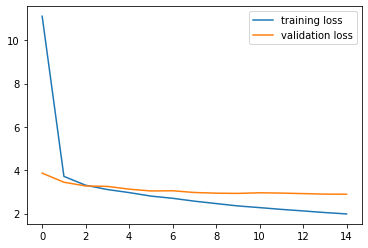

In [11]:
plt.figure()
plt.plot(epoch_loss, label='training loss')
plt.plot(epoch_vl, label='validation loss')
plt.legend()
plt.show()
plt.close('all')

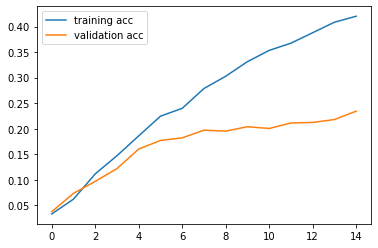

In [12]:
plt.figure()
plt.plot(epoch_acc, label='training acc')
plt.plot(epoch_va, label='validation acc')
plt.legend()
plt.show()
plt.close('all')

## Test on Other Folds

In [13]:
PiczakNet.evaluate(f3_processed, lf3_processed)

113/113 [==============================] - 1s 10ms/step - loss: 2.8900 - accuracy: 0.2342


[2.890044689178467, 0.23416666686534882]

In [14]:
PiczakNet.evaluate(f1_processed, lf1_processed)

113/113 [==============================] - 1s 10ms/step - loss: 1.8697 - accuracy: 0.5103


[1.869663119316101, 0.5102777481079102]

In [15]:
PiczakNet.evaluate(f2_processed, lf2_processed)

113/113 [==============================] - 1s 10ms/step - loss: 3.1947 - accuracy: 0.2167


[3.194734811782837, 0.21666666865348816]

In [16]:
PiczakNet.evaluate(f4_processed, lf4_processed)

113/113 [==============================] - 1s 10ms/step - loss: 1.8739 - accuracy: 0.4961


[1.8739123344421387, 0.496111124753952]

In [17]:
PiczakNet.evaluate(f5_processed, lf5_processed)

113/113 [==============================] - 1s 10ms/step - loss: 1.8478 - accuracy: 0.5283


[1.8477529287338257, 0.528333306312561]

## Predict

In [18]:
print(f4_processed[0].shape)

input_sample = np.expand_dims(f4_processed[0], axis=0)

print(input_sample.shape)

(60, 41, 2)
(1, 60, 41, 2)


In [19]:
prediction = PiczakNet.predict(input_sample)

[[3.05289374e-04 2.50326593e-07 1.07746676e-03 1.46791053e-05
  9.51309539e-06 1.19693514e-05 1.29838390e-05 7.05054845e-05
  1.05199184e-07 9.53093058e-06 4.25579913e-07 2.56510742e-08
  3.76057005e-06 2.41078685e-10 8.90753597e-07 3.90005094e-04
  3.49162899e-09 5.01191062e-06 9.95816845e-06 4.78273634e-08
  4.34632557e-06 1.12074399e-02 2.57830948e-06 4.49822139e-04
  6.28726278e-03 1.40982727e-03 6.04128290e-04 1.46000573e-07
  1.07413121e-06 2.05983385e-03 3.77015653e-03 5.21535640e-06
  1.11195652e-04 1.56743808e-05 3.47508956e-03 1.20490967e-07
  3.92100183e-08 1.62788353e-06 1.01745398e-04 8.92927230e-04
  8.19460837e-08 1.53498434e-06 3.67243858e-09 6.42887244e-07
  7.09167978e-08 1.74247106e-08 2.42354048e-09 2.12821210e-08
  8.93650304e-06 9.67666030e-01]]


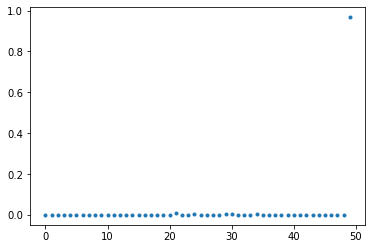

In [20]:
print(prediction)
plt.figure()
plt.plot(prediction[0], '.')
plt.show()

In [21]:
category = np.argmax(prediction, axis=1)
print(category)

print(lf4_processed.shape)
label_category = np.argmax(lf4_processed[0], axis=0)
print(label_category)

[49]
(3600, 50)
49


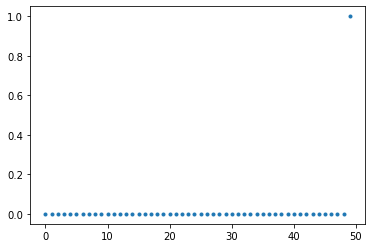

In [22]:
plt.figure()
plt.plot(lf4_processed[0], '.')
plt.show()

In [23]:
IPython.display.Audio(af4[0], rate=22050)